In [74]:
# home team         away team                                    season,datetime,referee
# fthg-predict      ftag-predict        **ftr-sanity check
# hthg              htag                **half time result
# hs                as
# hst               ast
# hc                ac
# hf                af
# hy                ay
# hr                ar  
# ftr_num
# htr-num
 

## Feature eng

In [3]:
import pandas as pd
data_path=r"epl_23-f.csv"
data=pd.read_csv(data_path,encoding='windows-1254')
data.columns=[i.lower() for i in data.columns]
data.datetime=pd.to_datetime(data.datetime).dt.date
data.drop(data.loc[data['season'].str.contains('1993|1994|1995|1996|1997|1998|1999',regex=True)].index,inplace=True)
data.sort_values(['datetime','hometeam','awayteam','referee'],ascending=True,inplace=True) #this be the unique order
data.reset_index(drop=True,inplace=True)
# no matter what happens i always want the above code to be running


def transform1(data):
    """some tranasformations and features"""
    win_map={'H':0,'D':1,'A':2}
    points_h_map={'H':3,'D':1,'A':0}
    points_a_map={'H':0,'D':1,'A':3}
    data['home_pnts']=data['ftr']
    data['away_pnts']=data['ftr']
    data['ftr_num']=data['ftr'].map(win_map) #point home team got in that match
    data['htr_num']=data['htr'].map(win_map) #points awa team got in that match
    data['home_pnts']=data['home_pnts'].map(points_h_map)
    data['away_pnts']=data['away_pnts'].map(points_a_map)
    return data
data=transform1(data)

In [4]:
columns_to_sort_by=data.select_dtypes('object').drop(['season','ftr','htr'],axis=1).columns.tolist()
columns_to_taransform=data.select_dtypes(include=['float64','int64']).columns.tolist()


In [5]:
# (data.groupby('datetime',as_index=False)['referee'].value_counts()['count']!=1).sum()
object_d=list(data.select_dtypes('object').drop(['hometeam','awayteam'],axis=1).columns) #[:7]
int_d=['ftr_num','htr_num'] #[7:9]
home=['hometeam','fthg','hthg','hs','hst','hc','hf','hy','hr','home_pnts'] #[9:18]
away=['awayteam','ftag','htag','as','ast','ac','af','ay','ar','away_pnts'] #[18:]
data=data.reindex(columns=object_d+int_d+home+away)


import numpy as np
home_data=data[object_d+int_d+home]
away_data=data[object_d+int_d+away]
away_data.columns=object_d+int_d+home
combined_data=pd.concat([home_data,away_data],ignore_index=True)
combined_data['identification']=np.array([np.ones(home_data.shape[0]),np.zeros(home_data.shape[0])],dtype=np.int64).reshape(-1,1)

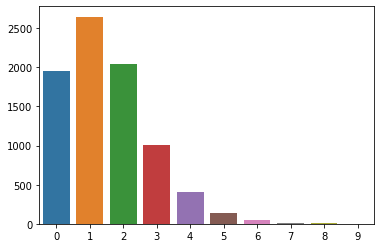

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.barplot(data.fthg.value_counts().index,data.fthg.value_counts().values);


In [119]:
import engine
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

trainx=engine.trainx
trainy1=engine.trainy1
trainy2=engine.trainy2
targets=engine.data[['ftg(H)','ftg(A)']]

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
dt=RandomForestClassifier()
dt.fit(trainx,targets.iloc[:trainx.shape[0]])



    

RandomForestClassifier()

In [120]:
preds=dt.predict(trainx)
preds=preds[:,0]-preds[:,1]
preds=preds/abs(preds)
preds=pd.DataFrame(preds,columns=['preds'])
preds=preds.fillna(0)

In [128]:
ori=engine.data.ftr[:trainx.shape[0]].map({'H':1,'D':0,'A':-1})
# preds['ori']=ori
# (preds['preds']==preds['ori']).sum()/preds.shape[0]

(preds['preds']==ori).sum()

3520

<AxesSubplot:>

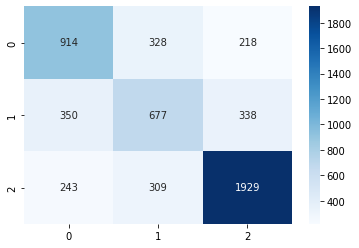

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(preds['ori'],preds['preds']),annot=True,fmt='d',cmap='Blues')

In [117]:
preds['preds'].value_counts()

 1.0    2485
-1.0    1507
 0.0    1314
Name: preds, dtype: int64

In [118]:
preds['ori'].value_counts()

 1    2481
-1    1460
 0    1365
Name: ori, dtype: int64

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
pp=Pipeline([('clf',RandomForestClassifier())])
pp[-1]


RandomForestClassifier()

In [5]:

pp[0].set_params(clf__n_estimators=100)

RandomForestClassifier()